In [6]:
# import what we need
import nltk
from nltk.stem.lancaster import LancasterStemmer ## used to stem words
import tensorflow
import random
import json
stemmer = LancasterStemmer()
import numpy as np
import tensorflow.keras as keras

# printing 
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# needed for GUI 
from tkinter import * 

In [7]:
# load json file
with open("intents.json") as file:
    data = json.load(file)

In [9]:
# view our json data
data['intents'][0:2]

[{'tag': 'greeting',
  'patterns': ['Hi',
   'How are you',
   'Is anyone there?',
   'Hello',
   'Good day',
   'Whats up'],
  'responses': ['Hello!',
   'Good to see you again!',
   'Hi there, how can I help?'],
  'context_set': ''},
 {'tag': 'goodbye',
  'patterns': ['cya',
   'See you later',
   'Goodbye',
   'I am Leaving',
   'Have a Good day',
   'Bye',
   'Adios'],
  'responses': ['Sad to see you go :(',
   'Talk to you later',
   'Goodbye!',
   'See you later',
   'Have a nice day',
   'Bye! Come back again soon.'],
  'context_set': ''}]

In [459]:
words = []
labels = []

docs_x = []
docs_y = [] 

# loop through dict to grab our values
for intent in data['intents']:
    for pattern in intent['patterns']:
        # stemming get the root of word, when traiing model 
        # only care abt the main meaning of word
        # need to tokenize/split words
        wrds = nltk.word_tokenize(pattern)
        words.extend(wrds) ## add all wrds to list
        docs_x.append(wrds)
        # for each pattern add another item in this var to track what tag its part of
        # each entry in docs_x (tokenized words/wrds) will correspond to (intent) docs_y so we know how to classify
        # each of the patterns
        docs_y.append(intent['tag'])
        
        if intent['tag'] not in labels:
            labels.append(intent['tag']) # grab all diff tags we need

In [460]:
# stem words and remove duplicate words. also lower all words so dont confuse the network into 
# thinking spelling case has different meaning
words = [stemmer.stem(w.lower()) for w in words if w!= '?' ] # remove any Question marks, dont want this
words = sorted(list(set(words)))                             # to have any meaning to our model
# sort the labels also 
labels = sorted(labels)

In [461]:
# prepare data before we feed into the model 

# need to convert our text in lists to nums (One-hot-encoding) so our network can 
# categorize the data
training = [] # input data goes here 
output = [] 

out_empty = [0 for _ in range(len(labels))]

for x, doc in enumerate(docs_x):
    
    bag = [] # will be our bag of one hot encoded words
    wrds = [stemmer.stem(w) for w in doc] # stem all the words in patterns
    
    # go through all diff words in list that are stemmed
    # and add either 1 or 0 to bag of words depending on if this word is in the 
    # main words list "(words = sorted(list(set(words))))"
    for w in words:
        # if word here place 1 representing that word exists
        if w in wrds:
            bag.append(1)
        else:
            # word isn't here place 0
            bag.append(0)
    
    # now generate output that has either 0's or 1's representing the tag that is word
    output_row = out_empty[:]
    # will look through labels list and check where tag is in list and set that value to 1 
    # in the output_row 
    output_row[labels.index(docs_y[x])] = 1
    
    # now we have both lists that are now One-hot-encoded !!
    training.append(bag)
    output.append(output_row)


In [462]:
# turn lists into numpy array
training = np.array(training)
output = np.array(output)


In [463]:
# shape of output
output.shape

In [464]:
# shape of training
training.shape

In [465]:
# Multi-layer net with ReLU hidden layer

model = keras.models.Sequential()


model.add(keras.layers.Dense(8,input_dim=training.shape[1],activation='relu',
 bias_initializer=keras.initializers.Constant(0.1)))

model.add(keras.layers.Dense(8,activation='relu',
 bias_initializer=keras.initializers.Constant(0.1)))

model.add(keras.layers.Dense(8,activation='relu',
 bias_initializer=keras.initializers.Constant(0.1)))


model.add(keras.layers.Dense(8,activation='relu',
 bias_initializer=keras.initializers.Constant(0.1)))






# Output layer (size 6), softmax activation function
model.add(keras.layers.Dense(output.shape[1],activation='softmax'))

In [466]:
# Compile as above (default learning rate and other
# hyperparameters for the Adam optimizer).
# default learning rate for adam optimizer is 0.001

model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Nadam(learning_rate=0.001),
 metrics=[keras.metrics.CategoricalAccuracy()])

# Display the model
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 8)                 1088      
_________________________________________________________________
dense_186 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_187 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_188 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_189 (Dense)            (None, 21)                189       
Total params: 1,493
Trainable params: 1,493
Non-trainable params: 0
_________________________________________________________________


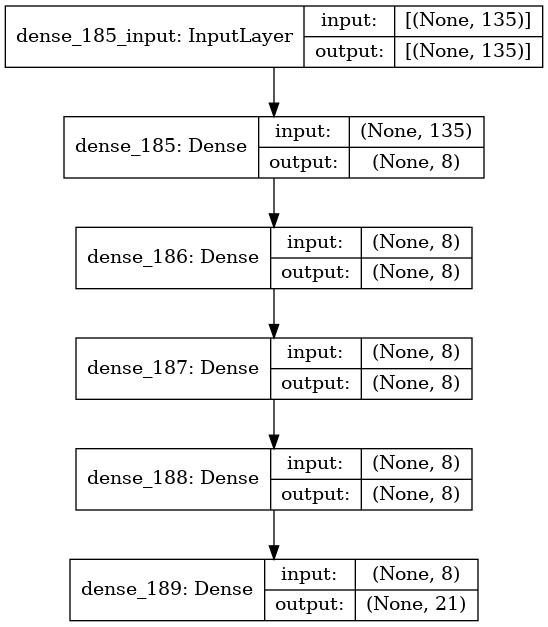

In [467]:
keras.utils.plot_model(model,to_file='chatbot.png',
 show_shapes=True,expand_nested=True)

In [370]:
# Note the initializer for the hidden unit bias weights
#for i in model.get_weights():
 #display(sp.Matrix(i))


In [468]:
# Train it!
history = model.fit(training, output,
 batch_size=1,
 epochs=100,
 verbose=1)

Train on 152 samples
Epoch 1/100
152/152 [==============================] - 1s 3ms/sample - loss: 3.0575 - categorical_accuracy: 0.0592
Epoch 2/100
152/152 [==============================] - 0s 3ms/sample - loss: 3.0329 - categorical_accuracy: 0.0789
Epoch 3/100
152/152 [==============================] - 0s 3ms/sample - loss: 3.0146 - categorical_accuracy: 0.0855
Epoch 4/100
152/152 [==============================] - 0s 3ms/sample - loss: 2.9881 - categorical_accuracy: 0.1250
Epoch 5/100
152/152 [==============================] - 0s 3ms/sample - loss: 2.9451 - categorical_accuracy: 0.1316
Epoch 6/100
152/152 [==============================] - 0s 3ms/sample - loss: 2.8590 - categorical_accuracy: 0.1908
Epoch 7/100
152/152 [==============================] - 0s 3ms/sample - loss: 2.7028 - categorical_accuracy: 0.1842
Epoch 8/100
152/152 [==============================] - 0s 3ms/sample - loss: 2.5121 - categorical_accuracy: 0.2039
Epoch 9/100
152/152 [==============================] - 0s 3

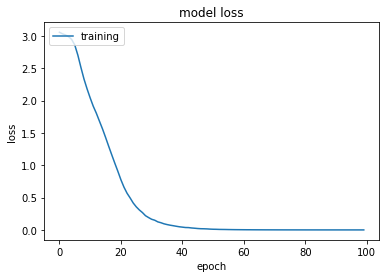

In [469]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper left')
plt.show()

In [471]:
score = model.evaluate(training,output,verbose=1)
print("Loss:",score[0])
print("Accuracy:",score[1])

Loss: 5.0991909167925386e-05
Accuracy: 1.0


In [ ]:
# save the model .. comment out for now until we train the data appropriately
model.save("model.Chatbot")

In [1]:
def bag_of_words(s, words):
    bag = [0 for _ in range(len(words))]

    s_words = nltk.word_tokenize(s)
    s_words = [stemmer.stem(word.lower()) for word in s_words]

    for se in s_words:
        for i, w in enumerate(words):
            if w == se:
                bag[i] = 1
            
    return numpy.array(bag)




In [2]:
def get_response(msg):
    
    results = model.predict(np.array([bag_of_words(msg, words)]))[0]
    results_index = np.argmax(results)
    tag = labels[results_index]
    
    for tg in data["intents"]:
        if tg['tag'] == tag:
            responses = tg['responses']

    return(random.choice(responses))
    
    
    

Here we will demo the chatbot. We created a Gui using the python package Tkinter in order to showcase our chatbot.

In [ ]:
BG_GRAY = "#ABB2B9"
BG_COLOR = "#17202A"
TEXT_COLOR = "#EAECEE"

FONT = "Helvetica 14"
FONT_BOLD = "Helvetica 13 bold"

bot_name = "Todd" # set the bot name for the instant message gui 

In [ ]:
class ChatApplication:
    
    def __init__(self):
        self.window = Tk()
        self._setup_main_window()
        
    def run(self):
        self.window.mainloop()
        
    def _setup_main_window(self):
        self.window.title("Chat")
        self.window.resizable(width=False, height=False)
        self.window.configure(width=900, height=550, bg=BG_COLOR)
        
        # head label
        head_label = Label(self.window, bg=BG_COLOR, fg=TEXT_COLOR,
                           text="Welcome", font=FONT_BOLD, pady=10)
        head_label.place(relwidth=1)
        
        # tiny divider
        line = Label(self.window, width=450, bg=BG_GRAY)
        line.place(relwidth=1, rely=0.07, relheight=0.012)
        
        # text widget
        self.text_widget = Text(self.window, width=20, height=2, bg=BG_COLOR, fg=TEXT_COLOR,
                                font=FONT, padx=5, pady=5)
        self.text_widget.place(relheight=0.745, relwidth=1, rely=0.08)
        self.text_widget.configure(cursor="arrow", state=DISABLED)
        
        # scroll bar
        h_scrollbar = Scrollbar(self.text_widget, orient = 'horizontal')
        h_scrollbar.place()
        h_scrollbar.configure(command=self.text_widget.xview)
        
        # bottom label
        bottom_label = Label(self.window, bg=BG_GRAY, height=80)
        bottom_label.place(relwidth=1, rely=0.825)
        
        # message entry box
        self.msg_entry = Entry(bottom_label, bg="#2C3E50", fg=TEXT_COLOR, font=FONT)
        self.msg_entry.place(relwidth=0.74, relheight=0.06, rely=0.008, relx=0.011)
        self.msg_entry.focus()
        self.msg_entry.bind("<Return>", self._on_enter_pressed)
        
        # send button
        send_button = Button(bottom_label, text="Send", font=FONT_BOLD, width=20, bg=BG_GRAY,
                             command=lambda: self._on_enter_pressed(None))
        send_button.place(relx=0.77, rely=0.008, relheight=0.06, relwidth=0.22)
        
        
    def _on_enter_pressed(self, event):
        msg = self.msg_entry.get()
        self._insert_message(msg, "You")
    
    
    def _insert_message(self, msg, sender):
        if not msg:
            return
        
        self.msg_entry.delete(0, END)
        msg1 = f"{sender}: {msg}\n\n"
        self.text_widget.configure(state=NORMAL)
        self.text_widget.insert(END, msg1)
        self.text_widget.configure(state=DISABLED)
        
        msg2 = f"{bot_name}: {get_response(msg)}\n\n"
        self.text_widget.configure(state=NORMAL)
        self.text_widget.insert(END, msg2)
        self.text_widget.configure(state=DISABLED)
        
        self.text_widget.see(END)

In [ ]:
# start the application
if __name__ == "__main__":
    app = ChatApplication()
    app.run()